In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython
from IPython.display import display
import seaborn as sns

## Pre-process
#### CGM

In [3]:
#CGM Readings

# RecID, PtID, ParentCITYDeviceUploadsID, DeviceDtTm, RecordType, Value, Units, SortOrd
df_cgm = pd.read_csv('Data-CITY/DeviceCGM.txt', sep='|', encoding='utf-16')
df_cgm["DeviceDtTm"] = pd.to_datetime(df_cgm["DeviceDtTm"], yearfirst=True)
#TODO: remove RecordType == Calibration?

#df_hypo = pd.read_csv('Data-CITY/DiabHypoEvent.txt', sep='|', encoding='utf-16')

In [4]:
#Calculate HbA1c (mean glucose level)
df_pt_hba1c = df_cgm.groupby("PtID")["Value"].mean()
df_pt_hba1c = df_pt_hba1c.to_frame()
df_pt_hba1c = df_pt_hba1c.rename(columns={"Value":"HbA1c"})


#### Patient Data

In [5]:
# Patient Data

# RecID|PtId|ParentLoginVisitID|MedicalCondition|MedCondPreStart|MedCondPreStartCat|MedCondPreStartTreat|MedCondDiagDt|MedCondDiagDtApprox|MedCondDiagDtUnk|MedCondTrt|MedCondResDt|MedCondResDtApprox|MedCondStatus|MedCondCurrTreatMed
df_pt_medical = pd.read_csv('Data-CITY/MedicalCondition.txt', sep='|', encoding='utf-16')

#RecID|PtID|SiteID|EnrollDt|RandDt|TrtGroup|AgeAsOfEnrollDt|StudyPhase|Phase1PtStatus|Phase2PtStatus|Phase3PtStatus|Phase2RandDt|Phase2StartDt|Phase2TrtGroup|Phase3RandDt|Phase3StartDt|Phase3TrtGroup
df_pt_roster = pd.read_csv('Data-CITY/PtRoster.txt', sep='|', encoding='utf-16')
df_pt_roster = df_pt_roster.rename(columns={"AgeAsOfEnrollDt":"Age"})
df_pt_roster = df_pt_roster[["PtID", "Age"]]

# RecID|PtID|ParentLoginVisitID|Visit|PhysExamNotDone|Weight|WeightUnits|WeightUnk|Height|HeightUnits|HeightUnk|BldPrSys|BldPrDia|BldPrUnk|PEHeartRt|PEHeartRtUnk|Temp|TempUnits|TempUnk|FingStkBG|FingStkBGUnits|FingStkBGUnk|PEAbnormal
df_pt_phys_raw = pd.read_csv('Data-CITY/DiabPhysExam.txt', sep='|', encoding='utf-16') #Weight (Kg/lbs), Height cm, Heart Rate, Temp, Abnormal condition

#lbs to kg
df_pt_phys = df_pt_phys_raw.copy()
mask = ( df_pt_phys["WeightUnits"] == 'lbs')
df_temp = df_pt_phys[mask]
df_pt_phys.loc[mask, 'Weight'] = df_temp["Weight"] * 0.453592

#in to cm
mask = ( df_pt_phys["HeightUnits"] == 'in')
df_temp = df_pt_phys[mask]
df_pt_phys.loc[mask, 'Height'] = df_temp["Height"] * 2.54

#PEAbnormal to 1 0
df_pt_phys["PEAbnormal"] = df_pt_phys["PEAbnormal"].replace({"Yes":1, "No":0})


# RecID|PtID|ParentLoginVisitID|EligCritMet|ExclCritAbsent|Sex|Ethnicity|Race|DiagDt|DiagDtApprox|DiagDtUnk|DiagAge|DiagAgeApprox|DiagAgeUnk|SHMostRecent|SHNumLast12Months|SHSeizComa|SHSeizComaLast12Months|DKAMostRecent|DKANumLast12Months|InsModPump|InsModInjections|InsModInhaled|InsModNone|PumpUse|PumpType|PumpTypeUnk|UnitsInsTotal|UnitsInsUnk|UnitsInsBasilOrLongAct|UnitsInsBasilOrLongActUnk|NumPumpBolusOrShortAct|NumPumpBolusOrShortActUnk|BGTestAvgNumMeter|BGTestMetDatNotAvail|BGTestAvgNumPtRep|BGTestPtRepNotAvail|CGMUseStat|CGMUseDur|CGMUseDevice|CGMUseLast1Month|CGMUseLast1MonthUnk|PhysExamNotDone|Weight|WeightUnits|WeightUnk|Height|HeightUnits|HeightUnk|BldPrSys|BldPrDia|BldPrUnk|PEAbnormal|PreExistMedCond|PtCurrMed|SHNumEverB|SHMostRecentB|SHLast12MonthsB|SHSeizComaNumB|SHSeizComaLast12MonthsB|DKANumEverB|DKAMostRecentB|DKALast12MonthsB
df_pt_screen = pd.read_csv('Data-CITY/DiabScreening.txt', sep='|', encoding='utf-16') #Weight, Height, Sex, Race, Insulin (Pump, Injections, Inhaled, None), Blood Pressure

#Sex to 1 0
df_pt_screen["Sex"] = df_pt_screen["Sex"].replace({"M":1, "F":0})

#Race One Hot encoding
df_pt_screen["Race"] = df_pt_screen["Race"].replace({'Black/African American': 'Black', 'More than one race': "Mixed", 'Unknown/not reported': "Unknown", 'American Indian/Alaskan Native': "Native"})
df_onehot = pd.get_dummies(df_pt_screen["Race"])
df_pt_screen = df_pt_screen.join(df_onehot)



# RecID|PtID|ParentLoginVisitID|EducationLevel|AnnualIncome|InsPrivate|InsMedicare|InsMediGap|InsMedicaid|InsSCHIP|InsMilitary|InsIndian|InsState|InsOtherGov|InsSingleService|InsNoCoverage|InsUnk|InsNoAns
df_pt_soc_eco = pd.read_csv('Data-CITY/DiabSocioEcon.txt', sep='|', encoding='utf-16') # Education, Annual Income

#EducationLevel to Years in Educations
df_pt_soc_eco["EducationLevel"] = df_pt_soc_eco["EducationLevel"].replace({
    "Master's Degree (MA, MS, MSW, MBA, MPH)": 16,
    "Bachelor's Degree (BS,BA,AB)": 15,
    'Professional Degree (MD, DDS, DVM, LLB, JD)': 15,
    'Associate Degree (AA)': 14,
    'Some college but no degree': 13,
    'High school graduate/diploma/GED': 12,
    '12th grade - no diploma': 11.5,
    '11th grade': 11,
    '10th grade' : 10,
    '9th grade' : 9,
    '7th or 8th grade' : 7.5,
    '1st, 2nd, 3rd, or 4th grade': 2.5,
    'Unknown': 0,
    'Does not wish to provide': 0,
})

#AnnualIncome to Int Thousands
df_pt_soc_eco["AnnualIncome"] = df_pt_soc_eco["AnnualIncome"].replace({
    'Unknown':0,
    'Does not wish to provide':0,
    'Less than $25,000':12.5,
    '$25,000 to less than $35,000': 30,
    '$35,000 to less than $50,000': 42.5,
    '$50,000 to less than $75,000': 62.5,
    '$75,000 to less than $100,000': 87.5,
    '$100,000 to less than $200,000': 150,
    '$200,000 or more': 200
})




# df_pt_medical = df_pt_medical[["PtID"]]
df_pt_phys = df_pt_phys[["PtID", "Weight", "Height", "PEHeartRt", "PEAbnormal"]]
df_pt_phys_mean = df_pt_phys[["PtID", "Weight", "Height", "PEHeartRt"]].groupby("PtID").mean()
df_pt_phys_max = df_pt_phys[["PtID", "PEAbnormal"]].groupby("PtID").max()
df_pt_phys = df_pt_phys_mean.join(df_pt_phys_max)


df_pt_screen = df_pt_screen[["PtID", "Sex", 'Black', 'White', 'Asian', 'Mixed', 'Unknown', 'Native']]
df_pt_soc_eco = df_pt_soc_eco[["PtID", "EducationLevel", "AnnualIncome"]]

# print(str(len(df_pt_medical)) + " | " + str(len(df_pt_medical["PtId"].unique())))
# print(str(len(df_pt_phys)) + " | " + str(len(df_pt_phys["PtID"].unique())))
# print(str(len(df_pt_screen)) + " | " + str(len(df_pt_screen["PtID"].unique())))
# print(str(len(df_pt_soc_eco)) + " | " + str(len(df_pt_soc_eco["PtID"].unique())))

##### Merge

In [6]:
df_pt_all = df_pt_phys.merge(df_pt_screen, on="PtID")
df_pt_all = df_pt_all.merge(df_pt_roster, on="PtID")
df_pt_all = df_pt_all.merge(df_pt_soc_eco, on="PtID")
df_pt_all = df_pt_hba1c.merge(df_pt_all, on="PtID")
df_pt_all = df_pt_all.set_index("PtID")

#calculate BMI
df_pt_all["BMI"] = (df_pt_all["Weight"] / (df_pt_all["Height"] * df_pt_all["Height"]))
df_pt_all["BMI"] = df_pt_all["BMI"] * (10000)

## Patient Data

In [7]:
# Devices Used

# RecID, PtID, DeviceManufact, DeviceModel, DeviceType, Visit
df_devices = pd.read_csv('Data-CITY/DeviceUploads.txt', sep='|', encoding='utf-16')
print(df_devices["DeviceManufact"].unique())
print(df_devices["DeviceModel"].unique())

['Dexcom']
['G5' 'G4' 'G6']


In [8]:
# Patient Race
# display(df_pt_screen["Race"].hist())

print(len( df_pt_screen[df_pt_screen["White"] == 1] ))

#Race = ['Black/African American', 'White', 'Asian', 'More than one race', 'Unknown/not reported', 'American Indian/Alaskan Native']

129


<Axes: >

[13.  14.  16.  15.  12.  11.5 10.   0.   7.5  9.  11.   2.5]
113


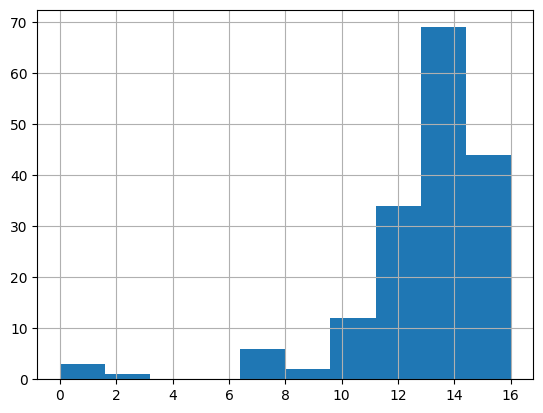

In [9]:
# Patient Education
display(df_pt_soc_eco["EducationLevel"].hist())
print(df_pt_soc_eco["EducationLevel"].unique())
print(len( df_pt_soc_eco[ df_pt_soc_eco["EducationLevel"] >= 13 ] ))

[ 62.5  12.5  30.  150.  200.   42.5   0.   87.5]
64.86928104575163 58.34814329910926


41

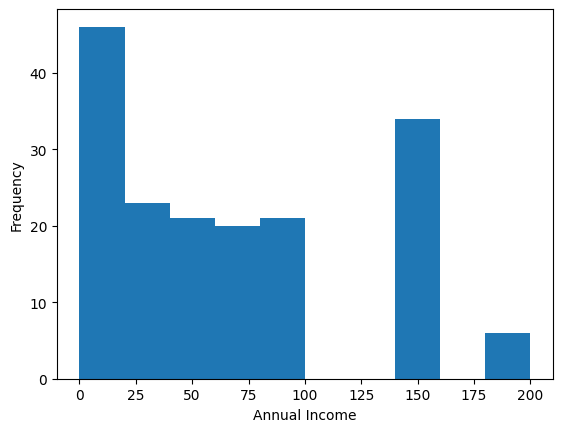

In [10]:
# Patient Income
plt.hist(df_pt_soc_eco["AnnualIncome"])
plt.xlabel("Annual Income")
plt.ylabel("Frequency")

print(df_pt_soc_eco["AnnualIncome"].unique())
print(df_pt_all["AnnualIncome"].mean(),df_pt_all["AnnualIncome"].std())

df_rich = df_pt_all["AnnualIncome"] < 25
(df_rich == True).sum()


74.26073832474076 16.215234879249337
169.10902723311548 10.284633572459345
25.95639165702139 5.148489042963641


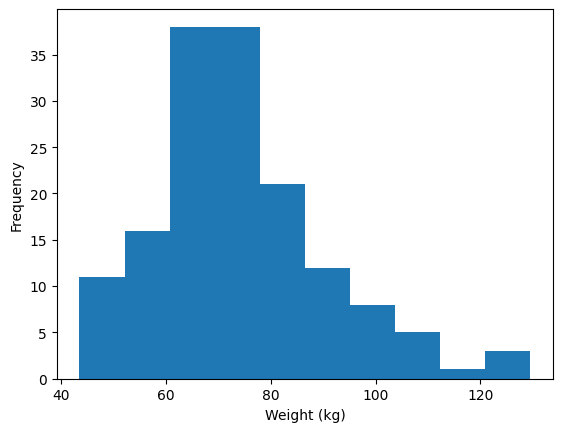

In [11]:
#Patient Weight
plt.hist(df_pt_all["Weight"])
plt.xlabel("Weight (kg)")
plt.ylabel("Frequency")

print(df_pt_all["Weight"].mean(),df_pt_all["Weight"].std())
print(df_pt_all["Height"].mean(),df_pt_all["Height"].std())
print(df_pt_all["BMI"].mean(),df_pt_all["BMI"].std())


Text(0, 0.5, 'Frequency')

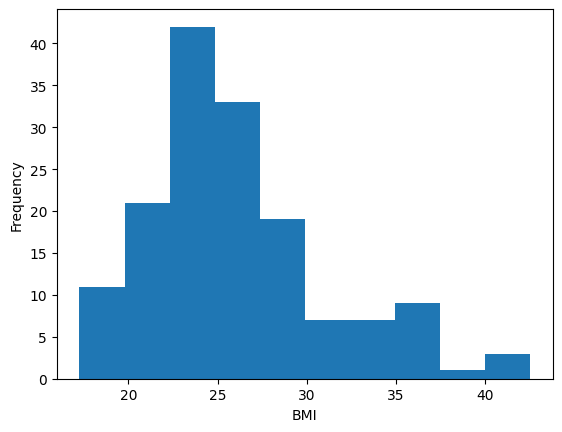

In [12]:
#Patient BMI
plt.hist(df_pt_all["BMI"])
plt.xlabel("BMI")
plt.ylabel("Frequency")

In [13]:
#Patient BMI
df_obese = df_pt_all["BMI"] > 40
(df_obese == True).sum()

3

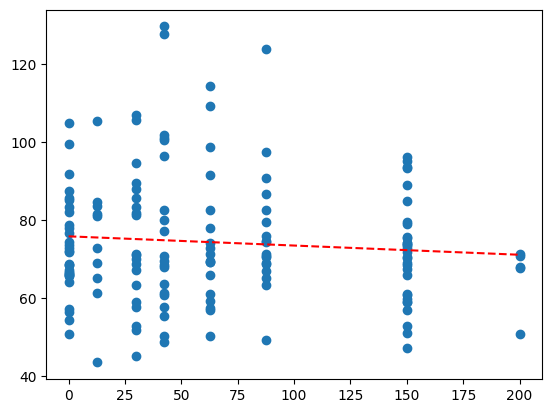

In [15]:
plt.scatter(df_pt_all["AnnualIncome"], df_pt_all["Weight"])

m, b = np.polyfit(df_pt_all["AnnualIncome"], df_pt_all["Weight"], 1)

x = np.linspace(0,200)
plt.plot(x, x*m+b, '--r')

-0.09553095823301008


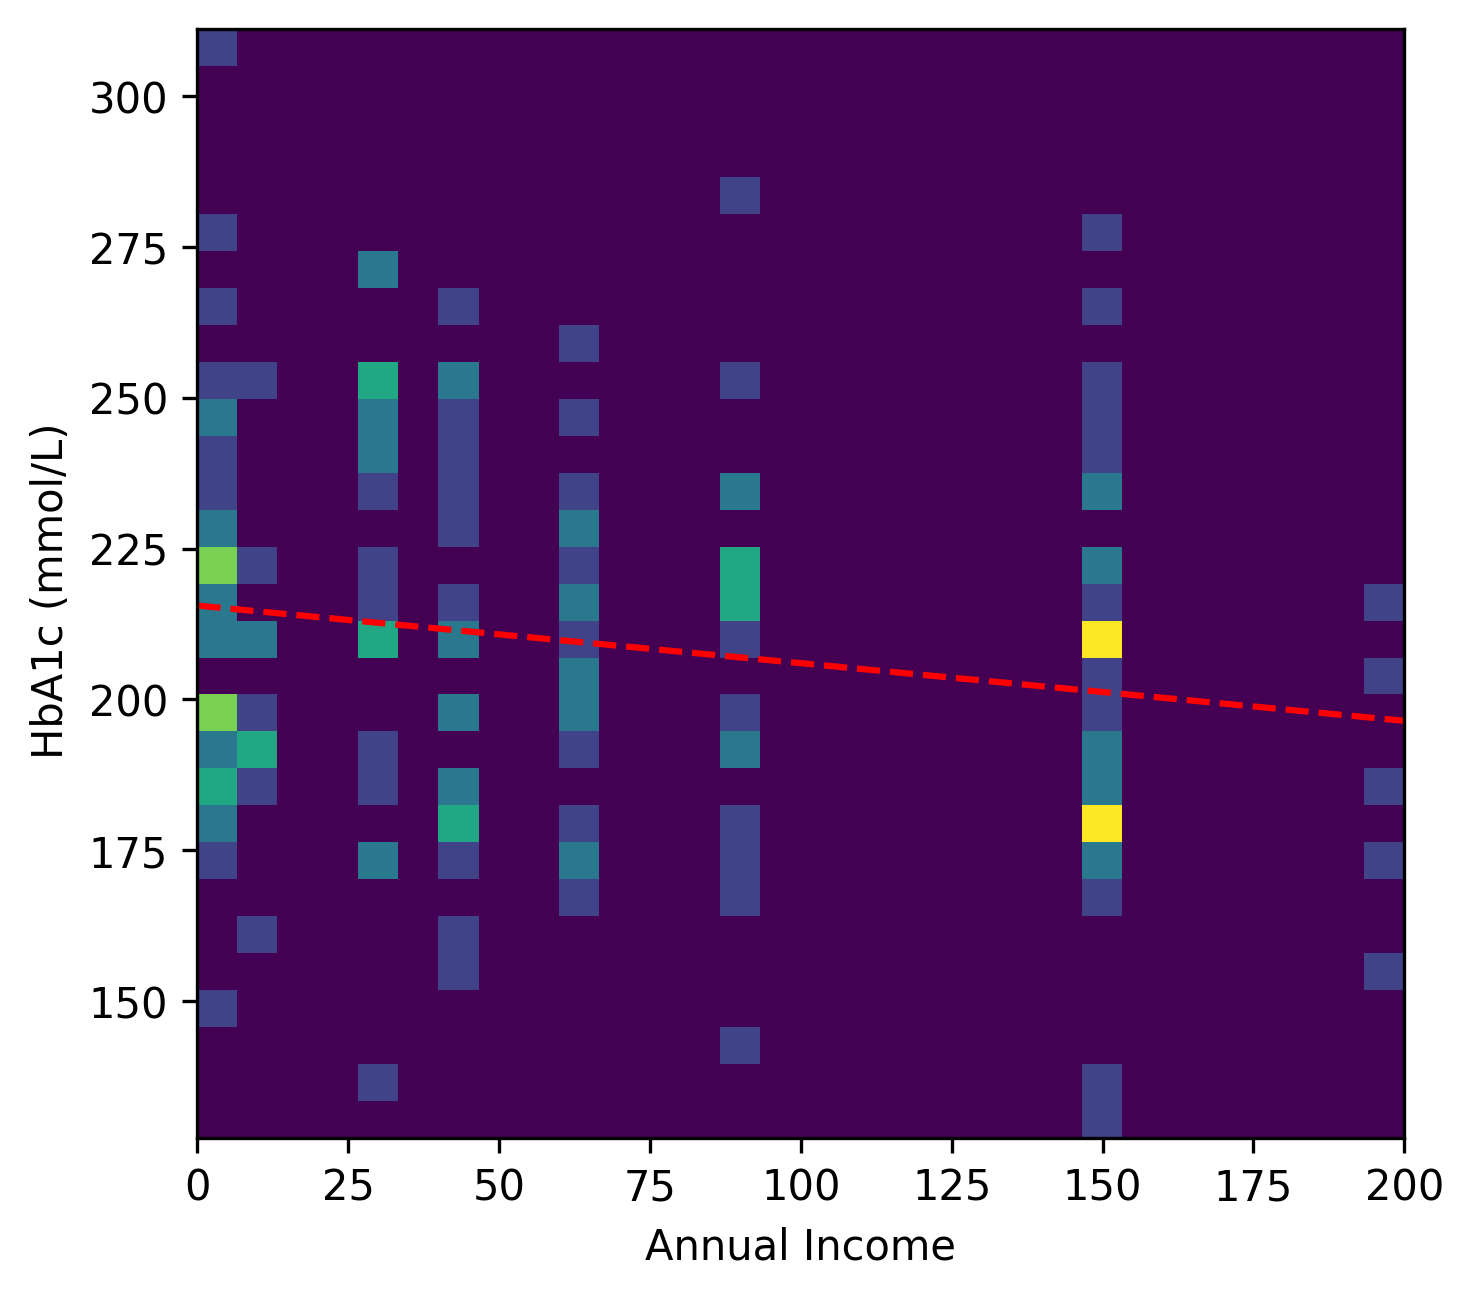

In [16]:

heatmap, xedges, yedges = np.histogram2d(df_pt_all["AnnualIncome"], df_pt_all["HbA1c"], bins=30)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

m, b = np.polyfit(df_pt_all["AnnualIncome"], df_pt_all["HbA1c"], 1)
print(m)

plt.gcf().set_dpi(300)
plt.clf()
plt.imshow(heatmap.T,extent=extent, origin='lower')

x = np.linspace(0,200)
plt.plot(x, x*m+b, '--r')

plt.xlabel("Annual Income")
plt.ylabel("HbA1c (mmol/L) ")
plt.show()

# plt.imshow(df_pt_all[["AnnualIncome", "Weight"]], cmap='hot', interpolation='nearest')
#
# fig, ax = plt.subplots(figsize=(5,5))
# sns.heatmap(df_pt_all[["AnnualIncome", "Weight"]], cmap='Blues', ax=ax)
# ax.set_title("Patient Detail Covariance")


In [17]:
df_pt_all.columns

Index(['HbA1c', 'Weight', 'Height', 'PEHeartRt', 'PEAbnormal', 'Sex', 'Black',
       'White', 'Asian', 'Mixed', 'Unknown', 'Native', 'Age', 'EducationLevel',
       'AnnualIncome', 'BMI'],
      dtype='object')

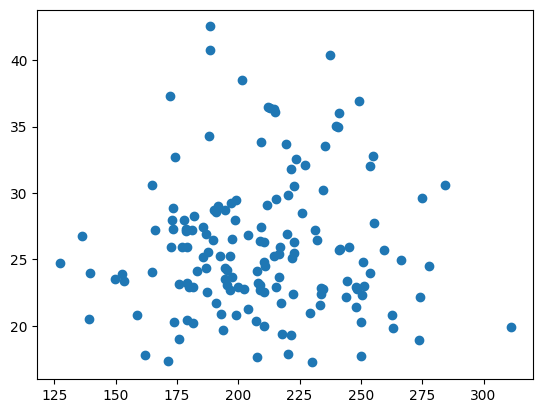

In [18]:
plt.scatter(df_pt_all["HbA1c"], df_pt_all["BMI"])

### Covariance

In [19]:
np.cov(df_pt_all["HbA1c"], df_pt_all["HbA1c"])

array([[1061.05686811, 1061.05686811],
       [1061.05686811, 1061.05686811]])

In [20]:
# vars = ['HbA1c', 'Weight', 'Height', 'PEHeartRt', 'PEAbnormal', 'Sex', 'Black','White', 'Asian', 'Mixed', 'Unknown', 'Native', 'Age', 'EducationLevel', 'AnnualIncome', 'BMI']

vars = ['HbA1c', 'Weight', 'Height', 'Sex', 'Age', 'EducationLevel', 'AnnualIncome', 'BMI']

matrix = df_pt_all[vars]
norm_matrix = matrix / matrix.max(axis=0)
cov_matrix = np.cov(norm_matrix.to_numpy().T)
# for i in range(8):
    # cov_matrix[i][i] = 0
out_matrix = (cov_matrix / cov_matrix.max()) * 10
# log_matrix = np.log(np.abs(cov_matrix))

print(cov_matrix.max())

# np.cov(matrix.to_numpy().T)

cov_matrix


0.25163398692810435


array([[ 0.01096664, -0.00063333, -0.00081373, -0.00078266, -0.00132928,
        -0.00119972, -0.005228  ,  0.00029895],
       [-0.00063333,  0.01566429,  0.00285394,  0.01440944,  0.00246481,
        -0.00061982, -0.00310214,  0.01241343],
       [-0.00081373,  0.00285394,  0.00265495,  0.01824686,  0.00111079,
         0.00068825, -0.00087788, -0.00086018],
       [-0.00078266,  0.01440944,  0.01824686,  0.25163399,  0.00404913,
         0.00351388, -0.00633009, -0.01140537],
       [-0.00132928,  0.00246481,  0.00111079,  0.00404913,  0.01466527,
         0.00034103, -0.01068853,  0.00113739],
       [-0.00119972, -0.00061982,  0.00068825,  0.00351388,  0.00034103,
         0.0215671 ,  0.00959225, -0.0018864 ],
       [-0.005228  , -0.00310214, -0.00087788, -0.00633009, -0.01068853,
         0.00959225,  0.08511265, -0.00199217],
       [ 0.00029895,  0.01241343, -0.00086018, -0.01140537,  0.00113739,
        -0.0018864 , -0.00199217,  0.01465703]])

### Correlation

In [21]:
vars = ['HbA1c', 'Weight', 'Height', 'Sex', 'Age', 'EducationLevel', 'AnnualIncome', 'BMI']

matrix = df_pt_all[vars]
norm_matrix = matrix / matrix.max(axis=0)
for i in range(8):
    cov_matrix[i][i] = 0
corr_matrix = np.corrcoef(norm_matrix.to_numpy().T) * 10
# log_matrix = np.log(corr_matrix)

corr_matrix

array([[10.        , -0.48321611, -1.50805563, -0.14898837, -1.04817614,
        -0.78009692, -1.71120423,  0.23579864],
       [-0.48321611, 10.        ,  4.42548681,  2.29512958,  1.6262333 ,
        -0.33722349, -0.84958803,  8.19244733],
       [-1.50805563,  4.42548681, 10.        ,  7.05952138,  1.78016593,
         0.90954657, -0.58399347, -1.37891458],
       [-0.14898837,  2.29512958,  7.05952138, 10.        ,  0.6665496 ,
         0.4769866 , -0.43254169, -1.87802703],
       [-1.04817614,  1.6262333 ,  1.78016593,  0.6665496 , 10.        ,
         0.19175709, -3.02535108,  0.77578413],
       [-0.78009692, -0.33722349,  0.90954657,  0.4769866 ,  0.19175709,
        10.        ,  2.23886308, -1.06099745],
       [-1.71120423, -0.84958803, -0.58399347, -0.43254169, -3.02535108,
         2.23886308, 10.        , -0.56403616],
       [ 0.23579864,  8.19244733, -1.37891458, -1.87802703,  0.77578413,
        -1.06099745, -0.56403616, 10.        ]])

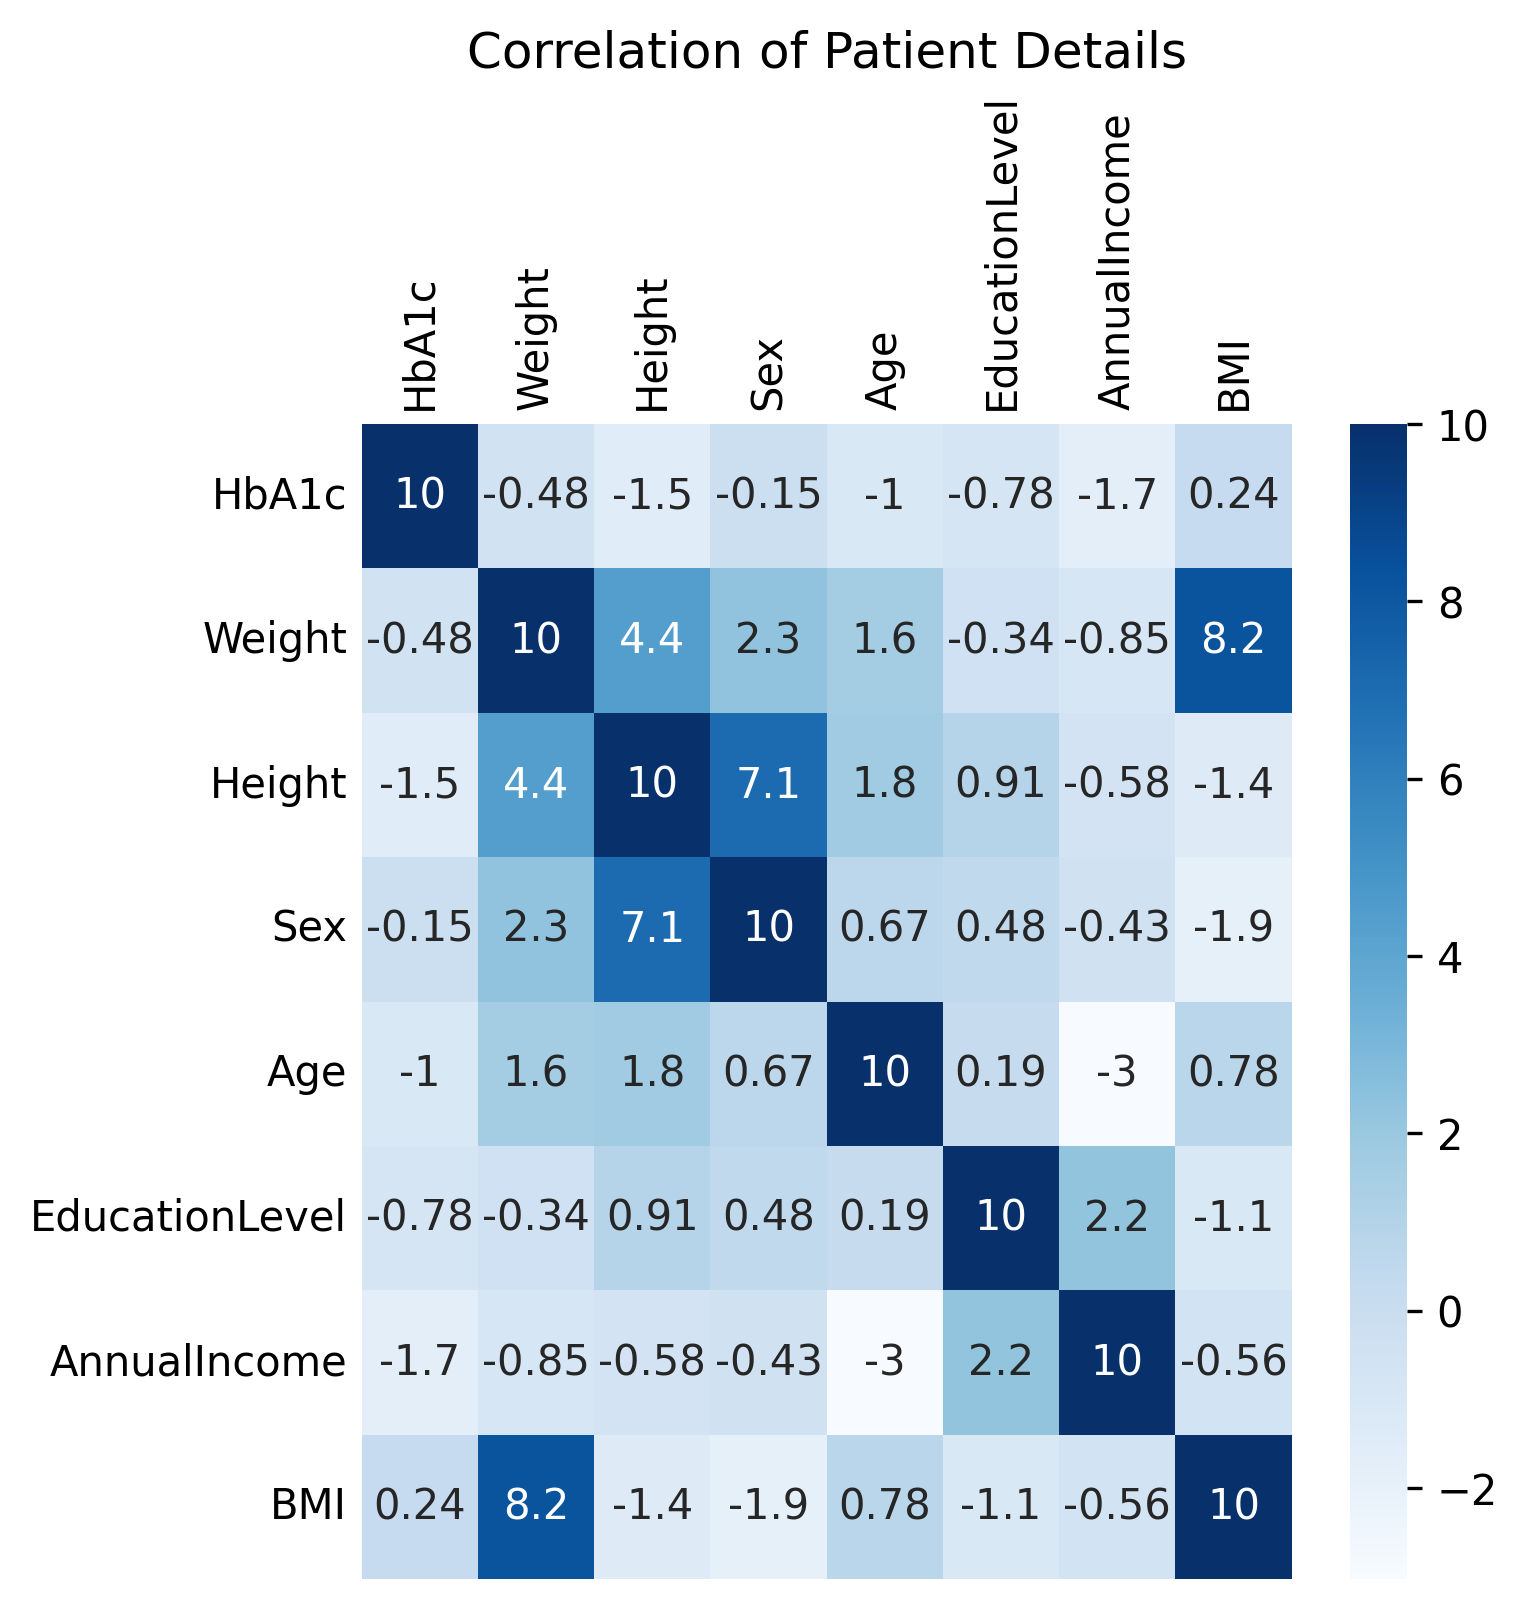

In [22]:
# sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', ax=ax)
ax.set_title("Correlation of Patient Details")

plt.gcf().set_dpi(300)
cols = matrix.columns.to_list()
ax.xaxis.tick_top()
ax.tick_params(length=0)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticklabels(cols, rotation=90)
ax.yaxis.set_ticklabels(cols, rotation=0)

plt.show()

## Clustering Patient

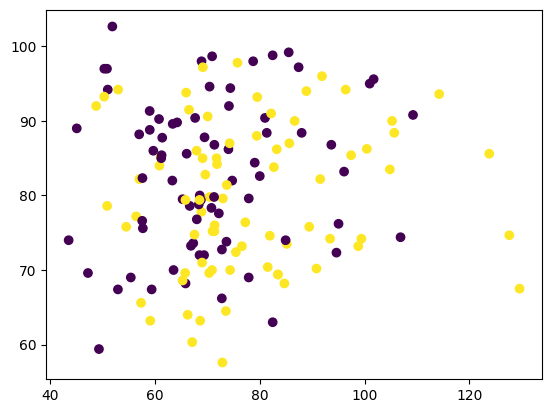

In [23]:
#Weight vs Heart Rate
plt.scatter(df_pt_all["Weight"], df_pt_all["PEHeartRt"], c=df_pt_all["Sex"], cmap="viridis")


<Axes: >

,HbA1c,Weight,Height,PEHeartRt,PEAbnormal,Sex,Black,White,Asian,Mixed,Unknown,Native,EducationLevel,AnnualIncome,BMI
Age,,,,,,,,,,,,,,,
14,27,27,27,26,27,27,27,27,27,27,27,27,27,27,27
15,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
16,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
17,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
18,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
19,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
20,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
21,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
22,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10


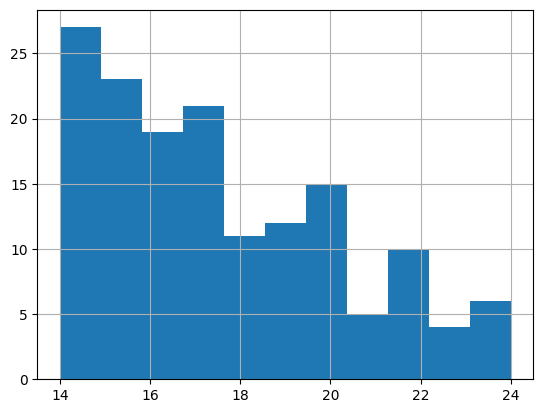

In [24]:
#Age
# df_pt_roster.plot.bar(x=df_pt_roster["Age"].unique(), y='Age', rot=0)
# plt.plot.bar(x=df_pt_roster["Age"].unique(), y=df_pt_roster['Age'], rot=0)
display(df_pt_all["Age"].hist(bins=24-13))
display(df_pt_all.groupby(["Age"]).count())

-8.253907543697283
86
36
31


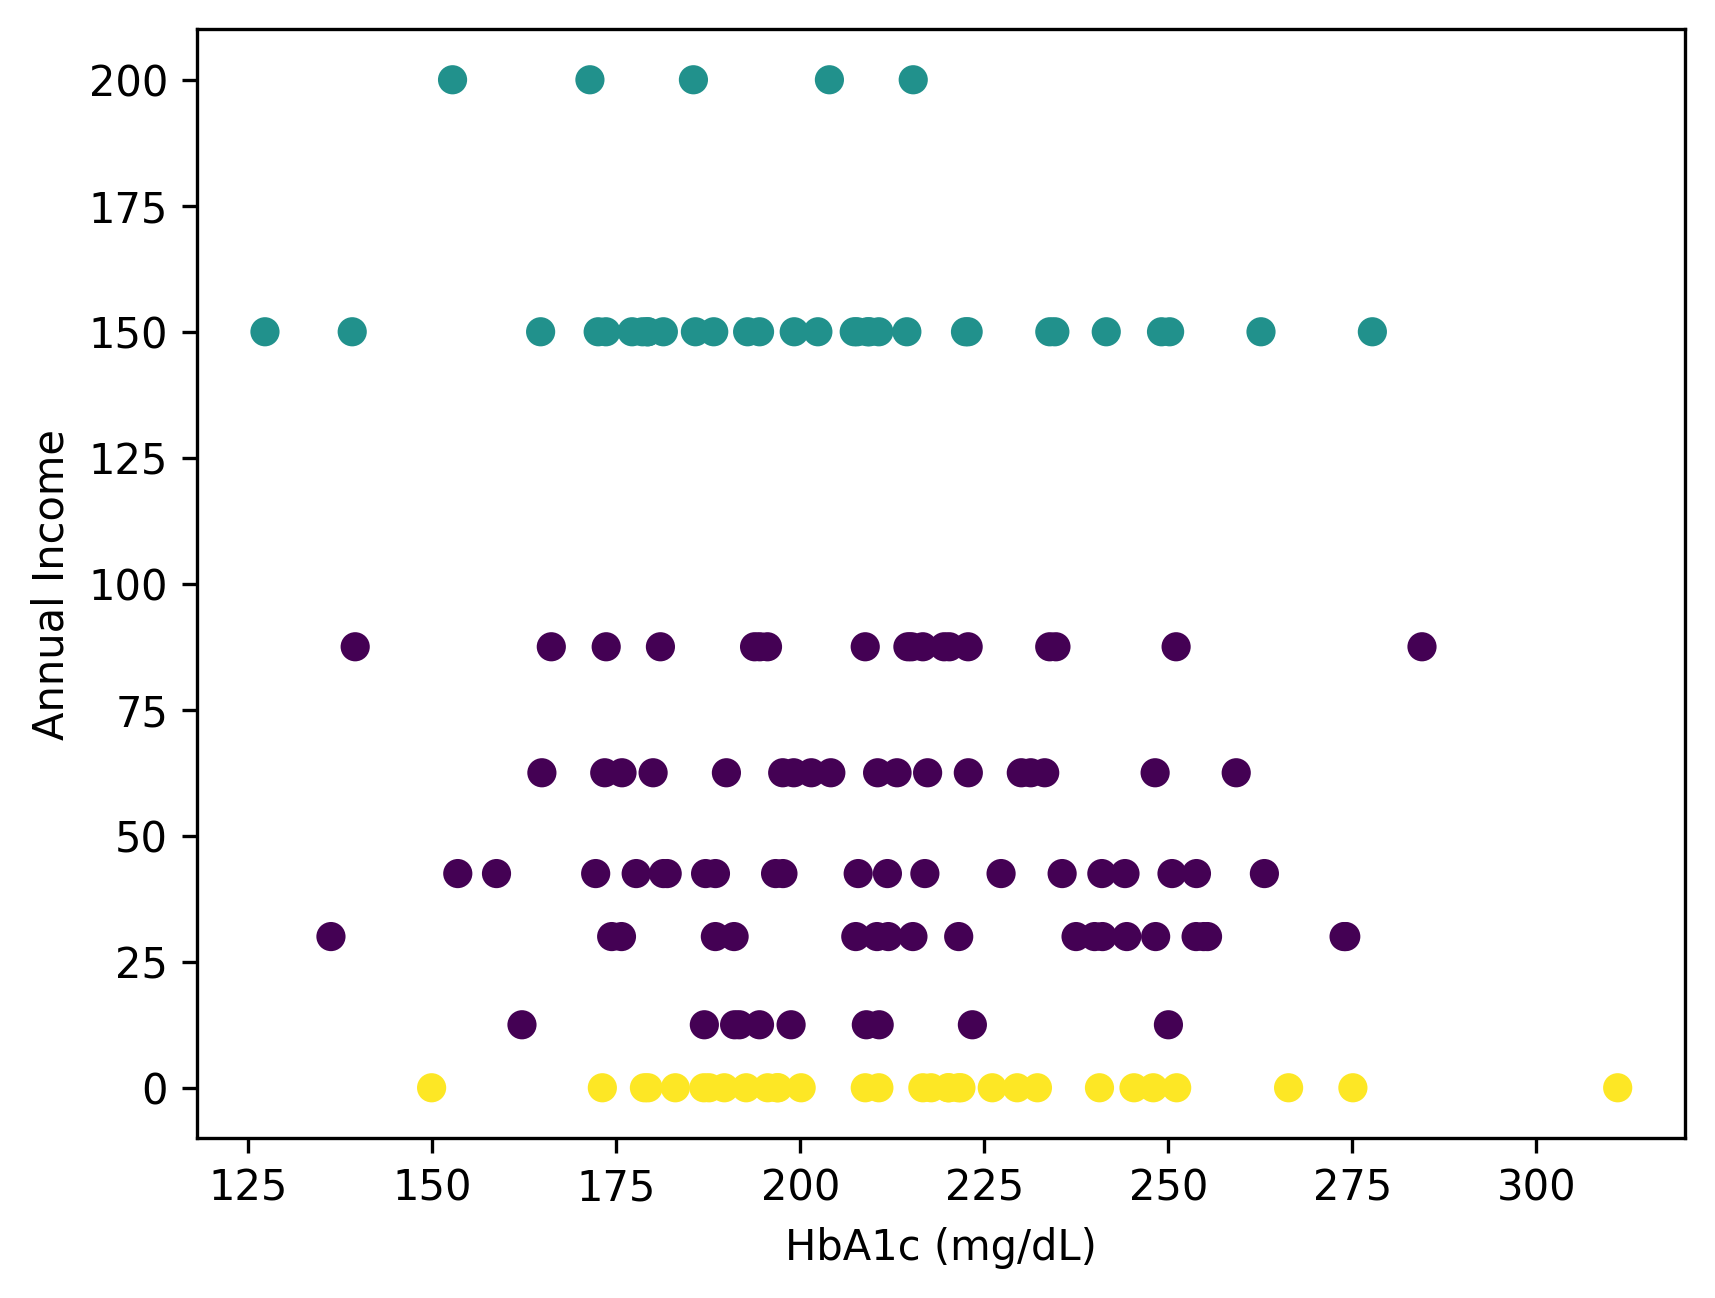

In [25]:
#cluster patients in groups
from sklearn.mixture import GaussianMixture

# print(df_pt_all)

num_groups = 3
# df_pt_groups_cols = ["HbA1c", "BMI", "Sex", "EducationLevel", "AnnualIncome", "Age"]
df_pt_groups_cols = ["HbA1c", "AnnualIncome"]

#did not include:
#   Race - patients predominantly white therefore group sizes imbalanced
#           large binary difference between binary and
#   AnnualIncome - not enough data?
# plt.gcf().set_dpi(300)


df_pt_groups_in = df_pt_all[df_pt_groups_cols]
gmm = GaussianMixture(n_components=num_groups, covariance_type='full', max_iter=200, n_init=20) #https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
gmm.fit(df_pt_groups_in)
# print(gmm.weights_)
print(gmm.lower_bound_)

labels = gmm.predict(df_pt_groups_in)
print(len(labels[labels == 0]))
print(len(labels[labels == 1]))
print(len(labels[labels == 2]))

plt.gcf().set_dpi(300)
plt.scatter(df_pt_all[df_pt_groups_cols[0]], df_pt_all[df_pt_groups_cols[1]], c=labels, cmap="viridis")
plt.xlabel("HbA1c (mg/dL)")
plt.ylabel("Annual Income")

df_pt_all["Group"] = labels



In [26]:
# df_pt_all["AnnualIncome"] +=

,Size,Mean_HbA1c,Mean_AnnualIncome,HbA1c,AnnualIncome
0,86,210.928697,49.709302,PtID 1 208.977691 2 198.756796 3 ...,PtID 1 12.5 2 12.5 3 87.5 6 ...
1,36,200.515141,156.944444,PtID 4 202.396562 5 207.334187 21 ...,PtID 4 150.0 5 150.0 21 150.0 25...
2,31,215.276852,0.000000,PtID 9 221.503738 12 220.200033 19 ...,PtID 9 0.0 12 0.0 19 0.0 22 0...


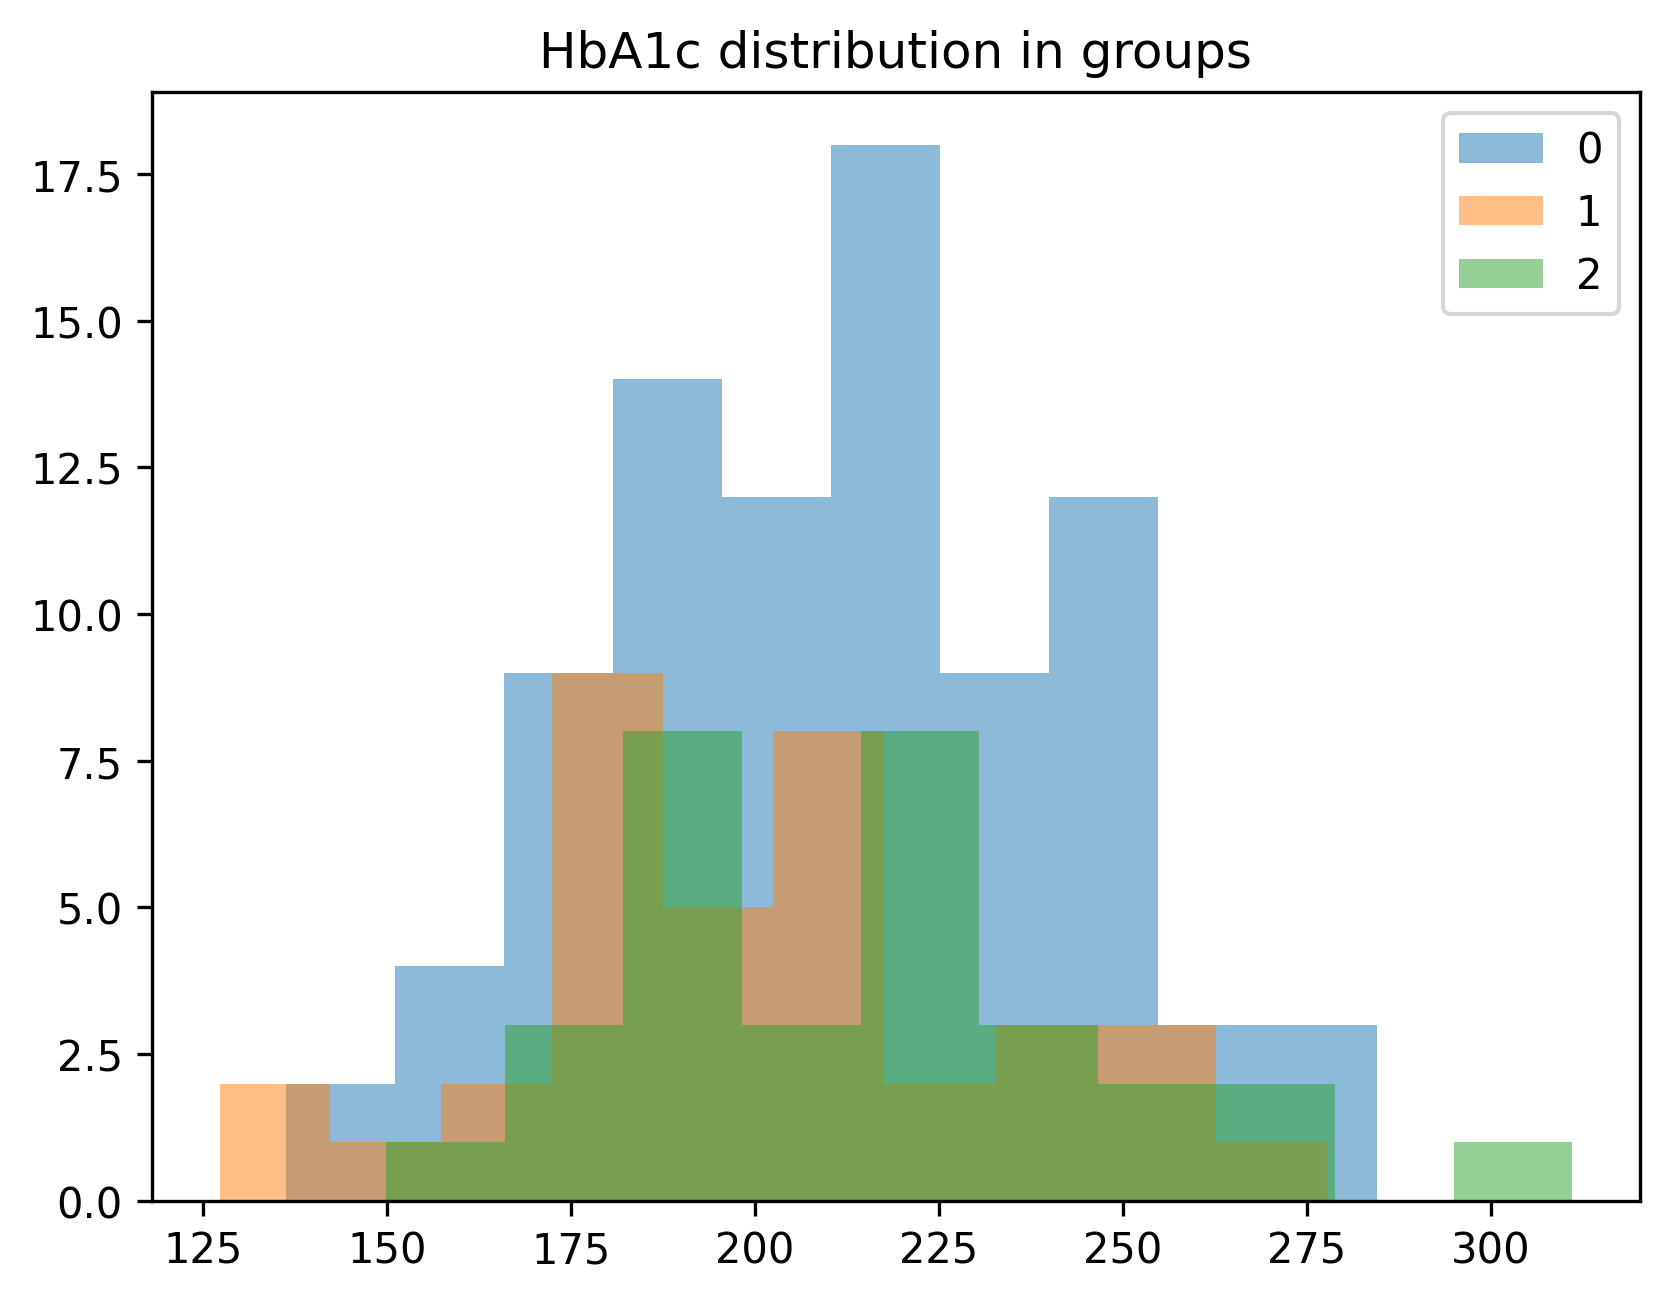

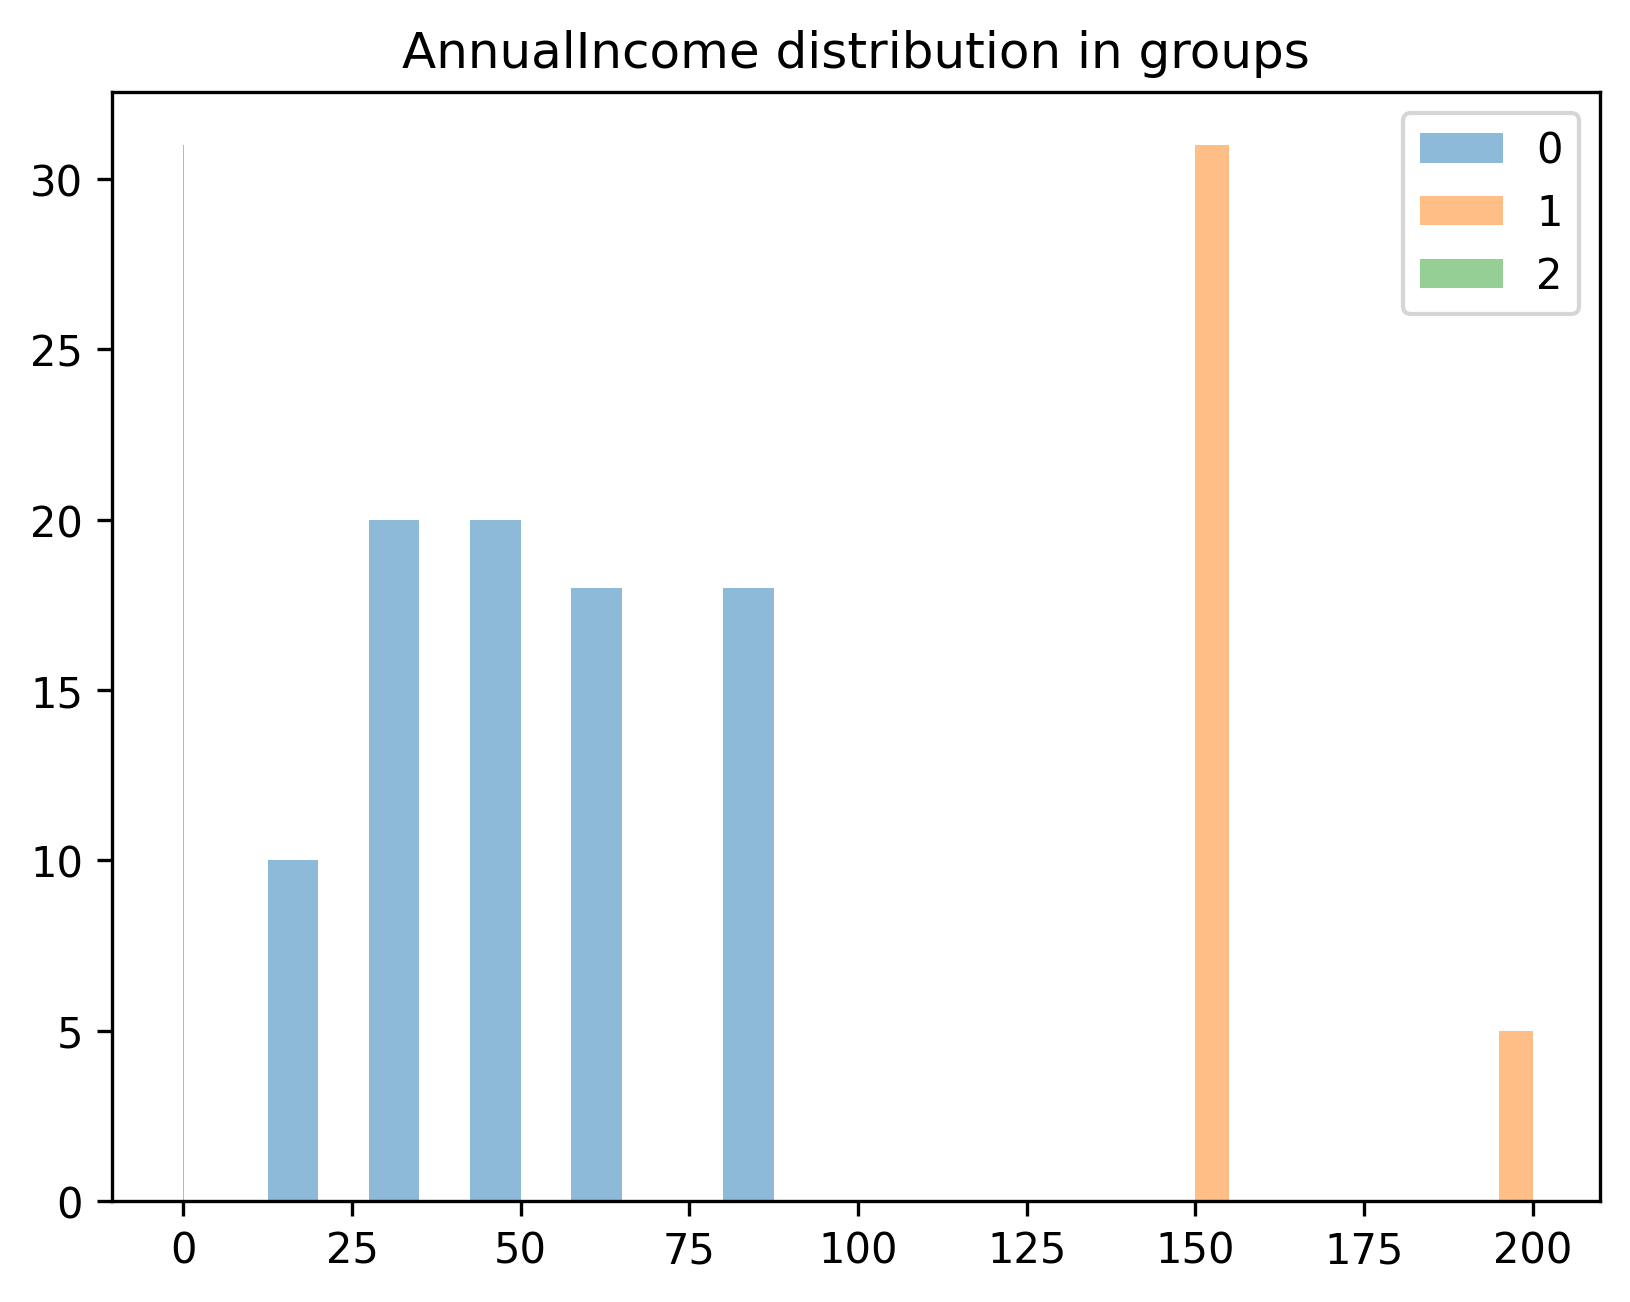

In [27]:
#analysis of each group

df_pt_all_groups = df_pt_all.groupby("Group")


outs = []
for name, group in df_pt_all_groups:
    out_dict = {}

    #get size of group
    out_dict['Size'] = len(group)

    #get mean of each column
    for col in df_pt_groups_cols:
        out_dict['Mean_'+col] = group[col].mean()

    for col in df_pt_groups_cols:
        # print(group[col].to_numpy)
        out_dict[col] = group[col]

    outs.append(out_dict)

df_pt_groups_plot = pd.DataFrame(outs)
# df_cgm_whisker = df_cgm_whisker.set_index('time')
display(df_pt_groups_plot)

for col in df_pt_groups_cols:
    plt.gcf().set_dpi(300)
    for i in range(0, len(df_pt_all_groups)):
        plt.hist(df_pt_groups_plot[col][i], alpha=1/len(df_pt_groups_cols), label=i, bins=10)
    plt.legend(loc='best')
    plt.title(col+" distribution in groups")
    plt.show()


## CGM Analysis

In [28]:
df_cgm_patients = df_cgm.groupby("PtID")

min: 2220
max: 110366


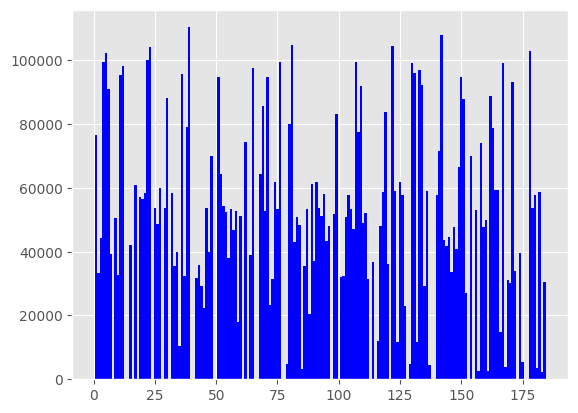

In [29]:
#size of each patients data
df_cgm_sizes = df_cgm_patients.size()
df_cgm_patients_id = df_cgm_patients.first().index

# display(df_cgm.groupby("PtID").count())
plt.style.use('ggplot')
plt.bar(df_cgm_patients_id.tolist(), df_cgm_sizes.to_numpy().tolist(), color="blue", log=False, width=1.0 )
print("min:", df_cgm_sizes.min())
print("max:", df_cgm_sizes.max())

### How similar is the cohort?

<Axes: title={'center': 'Value'}, xlabel='time'>

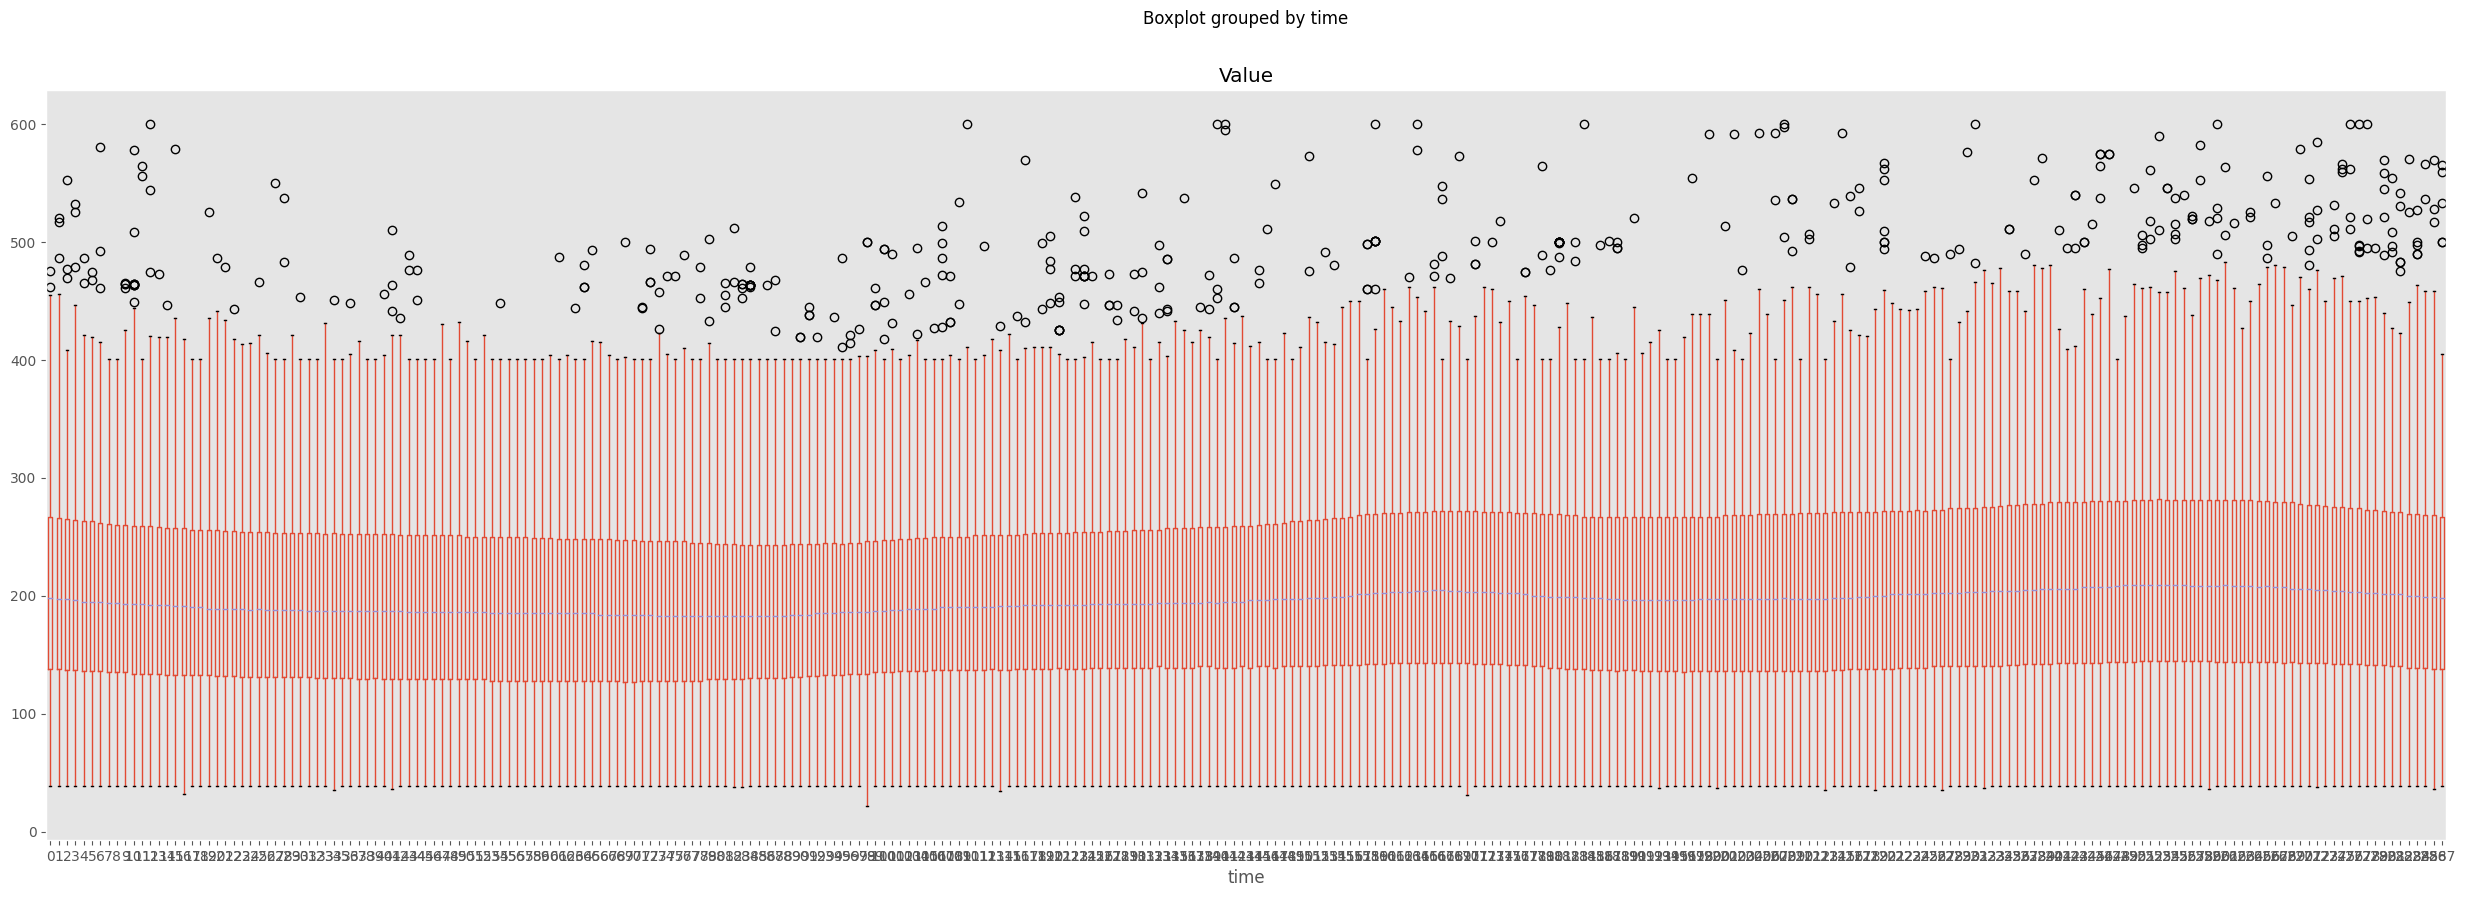

In [30]:
# df_cgm_small = df_cgm[:1000].copy()
df_cgm["time"] = df_cgm['DeviceDtTm'].dt.time
# df_cgm["time"] = df_cgm['time'].map(lambda t: t.hour * 60 + (t.minute - t.minute % 5) )
df_cgm["time"] = df_cgm['time'].map(lambda t: (t.hour * 60 + t.minute) // 5)

# display(df_cgm)
# print(len(df_cgm["time"].unique()))

df_cgm.boxplot(by="time", column="Value", grid=False, figsize=(30,10))



0
287


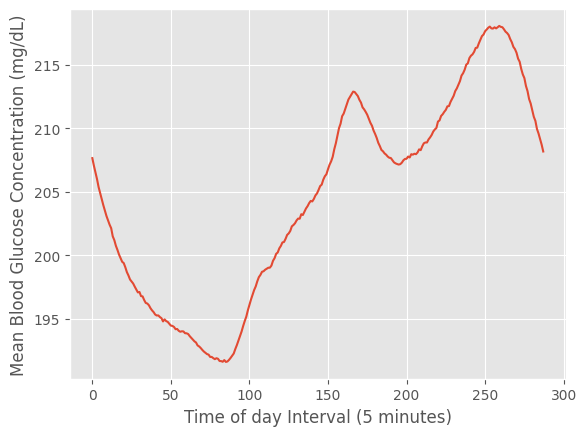

time
0      88.528525
1      88.346528
2      88.208891
3      88.107930
4      87.931214
         ...    
283    89.139328
284    89.103335
285    88.957010
286    88.831679
287    88.713391
Name: Value, Length: 288, dtype: float64

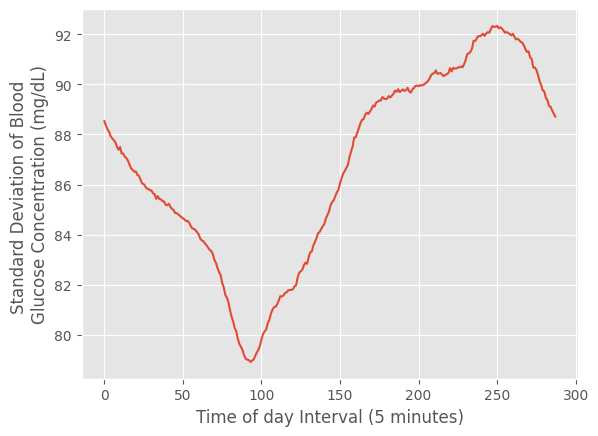

In [31]:
print(df_cgm["time"].min())
print(df_cgm["time"].max())

grouped = df_cgm.groupby(df_cgm["time"])
plt.plot(range(0,len(grouped["Value"])), grouped["Value"].mean())
plt.ylabel("Mean Blood Glucose Concentration (mg/dL)")
plt.xlabel("Time of day Interval (5 minutes)")
plt.show()
plt.plot(range(0,len(grouped["Value"])), grouped["Value"].std())
plt.ylabel("Standard Deviation of Blood \nGlucose Concentration (mg/dL)")
plt.xlabel("Time of day Interval (5 minutes)")


grouped["Value"].std()


In [32]:
df_high = df_cgm['Value'] < 100
print((df_high == True).sum())
print((df_high == True).sum() / len(df_cgm) * 100)

907250
10.844553117750749


In [33]:
df_cgm['Value'].mean()
df_cgm['Value'].mean()

204.56190180889178

Text(0, 0.5, 'Frequency')

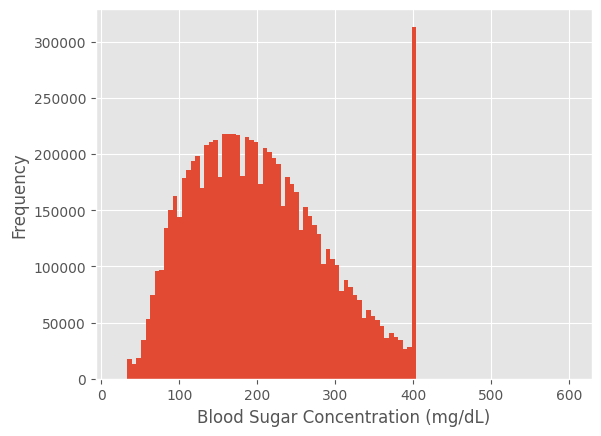

In [34]:
#HbA1c Distribution

cgm_avg = df_cgm.groupby('PtID')['Value'].mean()
plt.hist(df_cgm['Value'], bins=100)
plt.xlabel("Blood Sugar Concentration (mg/dL)")
plt.ylabel("Frequency")

In [35]:
import math
math.floor(1000 / 144) * 144

864

total len 7166736
295.72113821138214
50.0
562.3342655298138


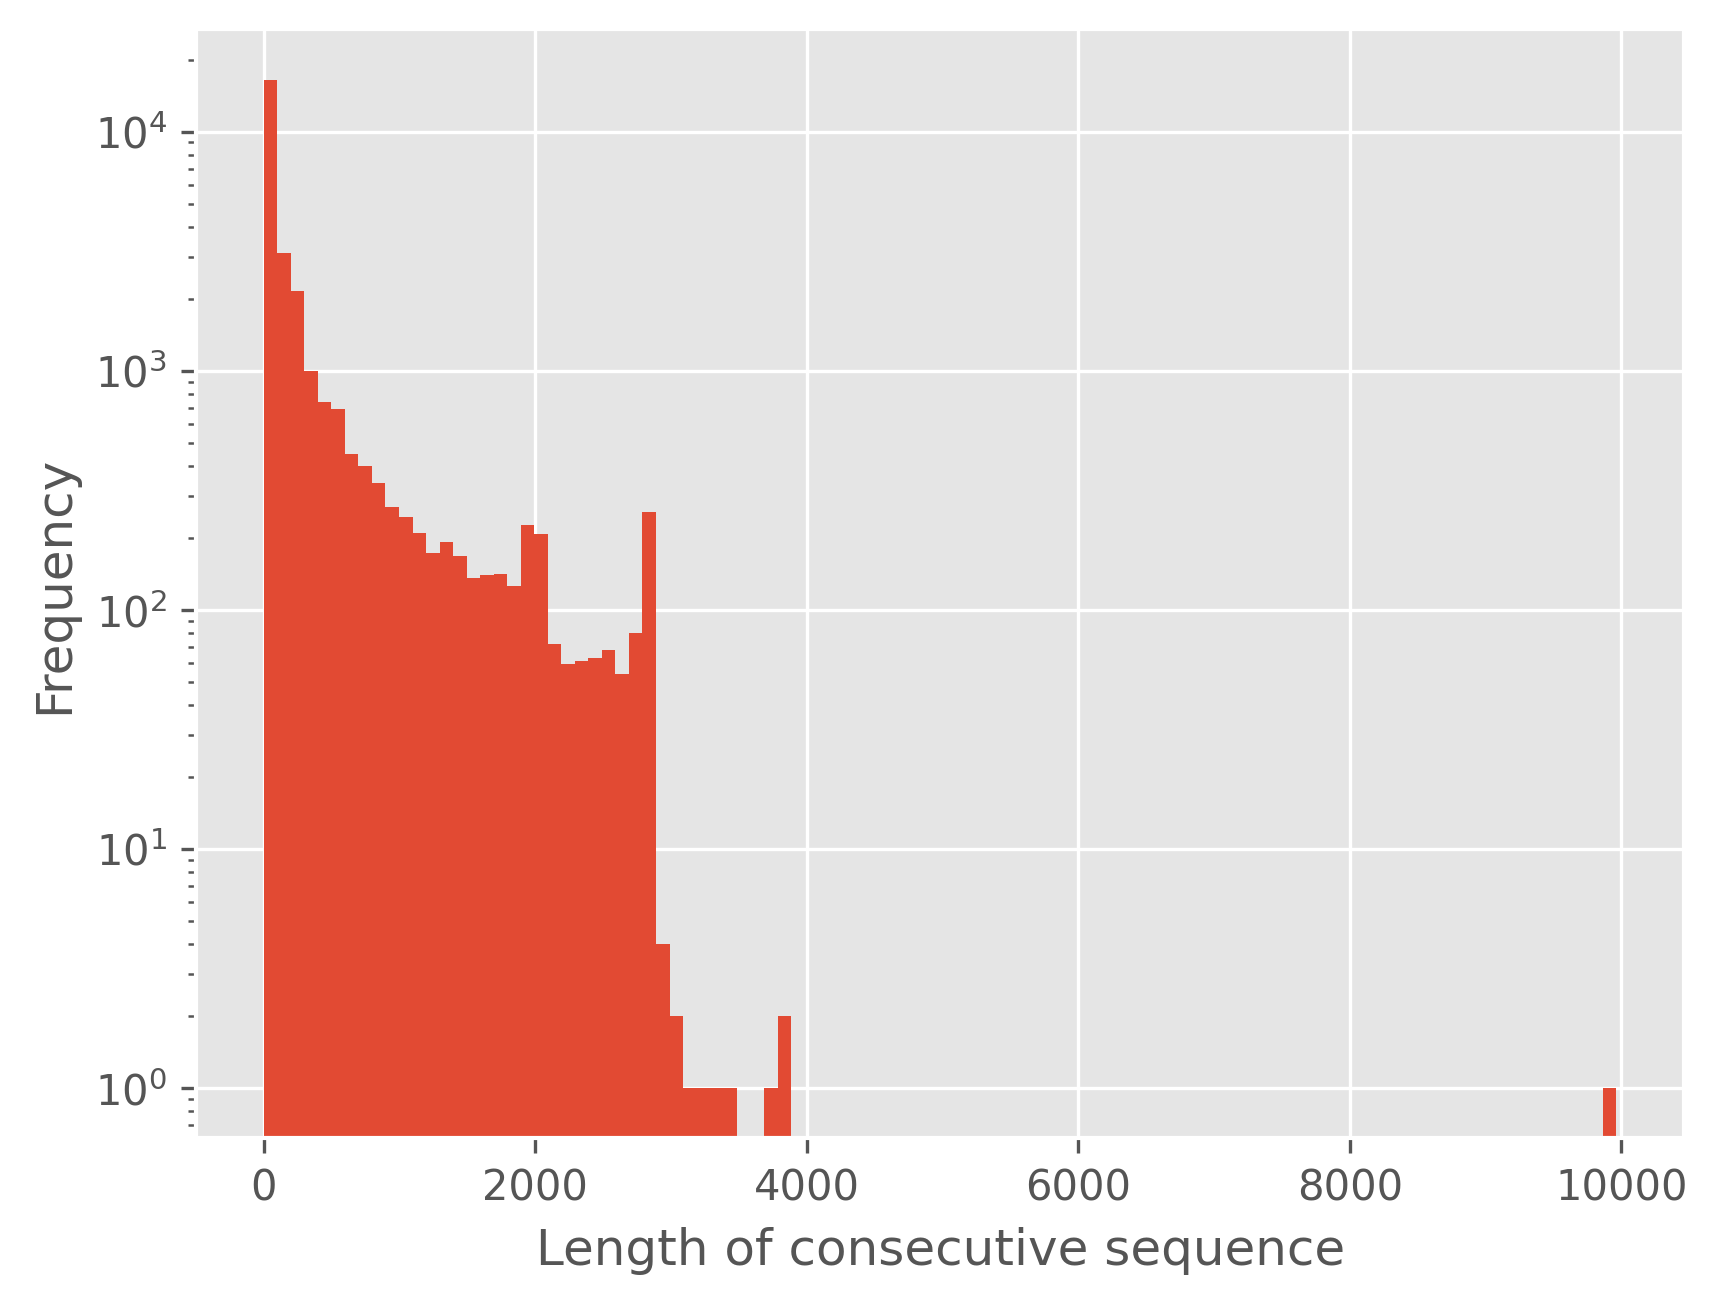

In [36]:
#Sequence Length Distribution

import math

pt_ids = df_pt_all.index

group_cgm =  df_cgm[df_cgm["PtID"].isin(pt_ids)]
group_cgm_pts = group_cgm.groupby("PtID")

total = 0
outs = []
for name, group_cgm_pt in group_cgm_pts:
    group_cgm_pt = group_cgm_pt.sort_values("DeviceDtTm")

    group_cgm_pt["Diff"] = group_cgm_pt["DeviceDtTm"].diff()
    group_cgm_pt["Diff_threshold"] = group_cgm_pt["Diff"] > pd.Timedelta(15,'m')
    group_cgm_pt["Sum"] = group_cgm_pt["Diff_threshold"].cumsum()
    group_cgm_pt_series = group_cgm_pt.groupby("Sum")


    for name, series in group_cgm_pt_series:
        outs.append(len(series))
        if len(series) >= 144:
            total += math.floor(len(series) / 144) * 144
            # total += len(series)
            # total += 1
        # out_dict = {"Length": len(series)}

outs = pd.Series(outs)

plt.gcf().set_dpi(300)
plt.hist(outs, bins=100)
plt.yscale("log")
plt.xlabel("Length of consecutive sequence")
plt.ylabel("Frequency")

print("total len", total)
print(outs.mean())
print(outs.median())
print(outs.std())

In [37]:
print(outs.max())

9963


In [38]:
df_high = outs >= 144
print((df_high == True).sum())
print((df_high == True).sum() / len(outs) * 100)

10379
36.68787557440792


## Training set creation

In [39]:
#Create Time series

def create_time_series(pt_ids, df_cgm):
    group_cgm =  df_cgm[df_cgm["PtID"].isin(pt_ids)]
    group_cgm_pts = group_cgm.groupby("PtID")


    total_days = 0
    total_series = 0
    #group_cgm_pt = group_cgm_pts.get_group(1)
    for name, group_cgm_pt in group_cgm_pts:
        group_cgm_pt = group_cgm_pt.sort_values("DeviceDtTm")

        group_cgm_pt["Diff"] = group_cgm_pt["DeviceDtTm"].diff()
        group_cgm_pt["Diff_threshold"] = group_cgm_pt["Diff"] > pd.Timedelta(15,'m')
        group_cgm_pt["Sum"] = group_cgm_pt["Diff_threshold"].cumsum()

        group_cgm_pt_series = group_cgm_pt.groupby("Sum")

        outs = []
        for name, series in group_cgm_pt_series:
            out_dict = {"Length": len(series)}
            if len(series) >= series_min_len:
                total_series += (len(series)-series_min_len)+1
            #TODO: split into chunks of size 144, shifted along by 1
            outs.append(out_dict)

        group_cgm_pt_series_hist = pd.DataFrame(outs)

        group_len = len(group_cgm_pt_series_hist[group_cgm_pt_series_hist["Length"] >= series_min_len])
        #print(group_cgm_pt["PtID"].values[0], ": ",  group_len , "/" ,len(group_cgm_pt_series_hist))
        total_days += group_len

    print("time series over 1 day: ", total_days)
    print("total data points for training: ", total_series)




series_min_len = 144

for i in range(0, num_groups):
    print("GROUP ", i)
    group_ids =  df_pt_all_groups.get_group(i).index
    #TODO: train_test split patients

    train_all = create_time_series(group_ids, df_cgm)
    #test_all = create_time_series(group_ids, df_cgm)


# group_cgm_pt_series_hist.hist()

# group_cgm_pt_break = group_cgm_pt[group_cgm_pt["Diff"] > pd.Timedelta(15,'m') ]
# plt.figure(figsize=(30,10))
# plt.plot(group_cgm_pt["DeviceDtTm"], group_cgm_pt["Value"])
# plt.scatter(group_cgm_pt_break["DeviceDtTm"], group_cgm_pt_break["Value"], color="red")

GROUP  0
time series over 1 day:  5521
total data points for training:  3296488
GROUP  1
time series over 1 day:  2793
total data points for training:  1891117
GROUP  2
time series over 1 day:  2065
total data points for training:  1203470
